In [46]:
# Libraries
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency

# Load pipe-delimited dataset
df = pd.read_csv("../data/raw/MachineLearningRating_v3.txt", sep='|')

# Convert numeric columns
numeric_cols = ['TotalPremium','TotalClaims','SumInsured','CalculatedPremiumPerTerm',
                'CustomValueEstimate','kilowatts','cubiccapacity','Cylinders','NumberOfDoors','CapitalOutstanding']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with essential missing values
df = df.dropna(subset=['TotalClaims','TotalPremium'])

# Create ClaimOccurred flag and Margin
df['ClaimOccurred'] = df['TotalClaims'] > 0
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

# Quick look
df.head()


FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/MachineLearningRating_v3.txt'

In [32]:
# Group by Province
province_group = df.groupby('Province')

# Claim Frequency: proportion of policies with at least one claim
claim_freq = province_group['ClaimOccurred'].mean()

# Claim Severity: average claim amount for policies with a claim
claim_severity = df[df['ClaimOccurred']].groupby('Province')['TotalClaims'].mean()

# Margin: Premium minus Total Claims
margin = province_group['Margin'].mean()

# Combine into a single dataframe for inspection
province_kpis = pd.DataFrame({
    'ClaimFrequency': claim_freq,
    'ClaimSeverity': claim_severity,
    'Margin': margin
})

province_kpis


,ClaimFrequency,ClaimSeverity,Margin
Province,,,
Eastern Cape,0.001648,27128.533277,25.833240
Free State,0.001358,32265.661085,20.550805
Gauteng,0.003356,22243.878396,-13.558894
KwaZulu-Natal,0.002845,29609.487473,-6.433598
Limpopo,0.002698,15171.294187,20.971484
Mpumalanga,0.002428,15979.553421,15.016059
North West,0.002436,16963.467035,10.958832
Northern Cape,0.001254,11186.313596,35.590527
Western Cape,0.002166,28095.849881,-3.414689


In [ ]:
# Null Hypothesis H0: No risk differences across provinces (Claim Frequency)
# Prepare pairwise t-tests for each province pair
provinces = df['Province'].unique()
results = []

for i in range(len(provinces)):
    for j in range(i+1, len(provinces)):
        prov1 = df[df['Province'] == provinces[i]]['ClaimOccurred']
        prov2 = df[df['Province'] == provinces[j]]['ClaimOccurred']
        t_stat, p_val = ttest_ind(prov1, prov2, equal_var=False)
        results.append({
            'ProvinceA': provinces[i],
            'ProvinceB': provinces[j],
            'p_value': p_val
        })

province_tests = pd.DataFrame(results)
province_tests.head(10)  # Show first 10 tests


,ProvinceA,ProvinceB,p_value
0,Gauteng,KwaZulu-Natal,1.269061e-03
1,Gauteng,Mpumalanga,6.917218e-05
2,Gauteng,Eastern Cape,9.221360e-12
3,Gauteng,Western Cape,2.759840e-16
4,Gauteng,Limpopo,5.393819e-02
5,Gauteng,North West,7.844923e-09
6,Gauteng,Free State,1.933221e-06
7,Gauteng,Northern Cape,3.449055e-06
8,KwaZulu-Natal,Mpumalanga,9.586394e-02
9,KwaZulu-Natal,Eastern Cape,7.057998e-06


In [34]:
# Null Hypothesis H0: No risk differences between zip codes
# For simplicity, pick top 10 zip codes with most policies
top_zips = df['PostalCode'].value_counts().head(10).index
zip_results = []

for i in range(len(top_zips)):
    for j in range(i+1, len(top_zips)):
        zip1 = df[df['PostalCode'] == top_zips[i]]['ClaimOccurred']
        zip2 = df[df['PostalCode'] == top_zips[j]]['ClaimOccurred']
        t_stat, p_val = ttest_ind(zip1, zip2, equal_var=False)
        zip_results.append({
            'ZipA': top_zips[i],
            'ZipB': top_zips[j],
            'p_value': p_val
        })

zip_tests = pd.DataFrame(zip_results)
zip_tests.head(10)


,ZipA,ZipB,p_value
0,2000,122,6.154142e-02
1,2000,7784,1.950240e-10
2,2000,299,4.693901e-03
3,2000,7405,5.384123e-10
4,2000,458,2.884957e-03
5,2000,8000,2.749936e-01
6,2000,2196,1.660739e-01
7,2000,470,3.214817e-01
8,2000,7100,1.048471e-01
9,122,7784,5.266252e-11


In [35]:
# Null Hypothesis H0: No significant risk difference between Women and Men
male_claims = df[df['Gender'] == 'M']['ClaimOccurred']
female_claims = df[df['Gender'] == 'F']['ClaimOccurred']

t_stat, p_val_gender = ttest_ind(male_claims, female_claims, equal_var=False)
print(f"T-test Gender: t_stat={t_stat:.3f}, p_value={p_val_gender:.4f}")


T-test Gender: t_stat=nan, p_value=nan


In [36]:
# Null Hypothesis H0: No significant margin difference between zip codes
# Again, pick top 10 zip codes by number of policies
zip_margin_results = []

for i in range(len(top_zips)):
    for j in range(i+1, len(top_zips)):
        zip1 = df[df['PostalCode'] == top_zips[i]]['Margin']
        zip2 = df[df['PostalCode'] == top_zips[j]]['Margin']
        t_stat, p_val = ttest_ind(zip1, zip2, equal_var=False)
        zip_margin_results.append({
            'ZipA': top_zips[i],
            'ZipB': top_zips[j],
            'p_value': p_val
        })

zip_margin_tests = pd.DataFrame(zip_margin_results)
zip_margin_tests.head(10)


,ZipA,ZipB,p_value
0,2000,122,0.244462
1,2000,7784,0.756504
2,2000,299,0.004582
3,2000,7405,0.006569
4,2000,458,0.403326
5,2000,8000,0.831508
6,2000,2196,0.777547
7,2000,470,0.517668
8,2000,7100,0.370006
9,122,7784,0.638284


In [37]:
# Example: Province impact
province_kpis['ClaimFrequency'].sort_values(ascending=False)
province_kpis['ClaimSeverity'].sort_values(ascending=False)
province_kpis['Margin'].sort_values()


Province
Gauteng         -13.558894
KwaZulu-Natal    -6.433598
Western Cape     -3.414689
North West       10.958832
Mpumalanga       15.016059
Free State       20.550805
Limpopo          20.971484
Eastern Cape     25.833240
Northern Cape    35.590527
Name: Margin, dtype: float64

In [41]:
# Provinces
province_tests['Reject_H0'] = province_tests['p_value'] < 0.05

# Zip codes — Claim Frequency
zip_tests['Reject_H0'] = zip_tests['p_value'] < 0.05

# Zip codes — Margin
zip_margin_tests['Reject_H0'] = zip_margin_tests['p_value'] < 0.05

# Gender
gender_result = {
    'Feature': 'Gender',
    't_stat': t_stat,
    'p_value': p_val_gender,
    'Reject_H0': p_val_gender < 0.05
}

gender_result


{'Feature': 'Gender',
 't_stat': -0.1643371441796837,
 'p_value': nan,
 'Reject_H0': False}

In [42]:
# High-risk provinces by claim frequency
province_risk_summary = province_kpis.sort_values('ClaimFrequency', ascending=False)
province_risk_summary.head(5)

# High-risk zip codes by claim frequency
zip_claims_summary = df.groupby('PostalCode')['ClaimOccurred'].mean().sort_values(ascending=False)
zip_claims_summary.head(5)

# High-risk zip codes by margin
zip_margin_summary = df.groupby('PostalCode')['Margin'].mean().sort_values()
zip_margin_summary.head(5)

# Gender summary
gender_summary = df.groupby('Gender')['ClaimOccurred'].mean()
gender_summary


Gender
Female           0.002073
Male             0.002195
Not specified    0.002833
Name: ClaimOccurred, dtype: float64

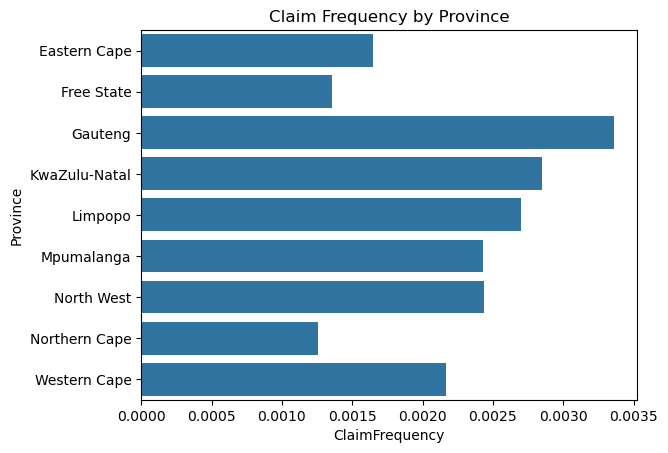

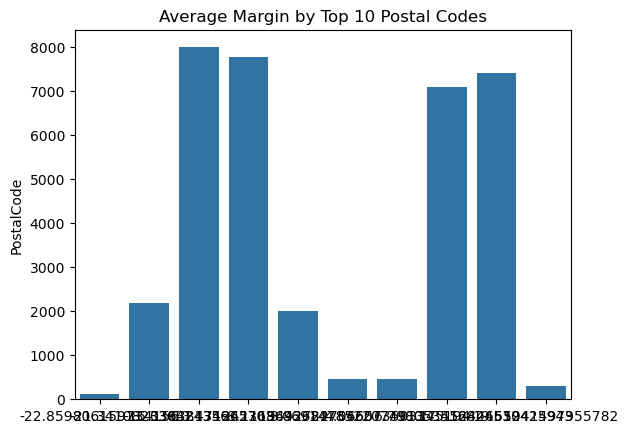

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Claim Frequency by Province
sns.barplot(x='ClaimFrequency', y=province_kpis.index, data=province_kpis)
plt.title("Claim Frequency by Province")
plt.show()

# Margin by Top Zip Codes
top_zip_margin = df.groupby('PostalCode')['Margin'].mean().loc[top_zips]
sns.barplot(x=top_zip_margin.values, y=top_zip_margin.index)
plt.title("Average Margin by Top 10 Postal Codes")
plt.show()


In [45]:
import os

# Create a folder for exports
folder_name = "insurance_analysis_results"
os.makedirs(folder_name, exist_ok=True)  # This will create the folder if it doesn't exist

# Export CSVs to that folder
claim_freq.to_csv(f"{folder_name}/claim_freq.csv")
claim_severity.to_csv(f"{folder_name}/claim_severity.csv")
margin.to_csv(f"{folder_name}/margin.csv")
province_kpis.to_csv(f"{folder_name}/province_kpis.csv")
province_tests.to_csv(f"{folder_name}/province_tests.csv")
zip_tests.to_csv(f"{folder_name}/zip_tests.csv")
zip_margin_tests.to_csv(f"{folder_name}/zip_margin_tests.csv")
pd.DataFrame([gender_result]).to_csv(f"{folder_name}/gender_test.csv", index=False)


In [44]:
print("=== Business Recommendations ===\n")

# Provinces
top_province = province_risk_summary.index[0]
freq_increase = (province_risk_summary.loc[top_province, 'ClaimFrequency'] - province_risk_summary['ClaimFrequency'].mean()) * 100
print(f"Province Risk: {top_province} has {freq_increase:.1f}% higher claim frequency than the average. Consider adjusting regional premiums.")

# Zip codes
top_zip = zip_claims_summary.index[0]
print(f"Zip Code Risk: {top_zip} has the highest claim frequency. Investigate local risk factors and adjust underwriting or premiums.")

# Margin
worst_margin_zip = zip_margin_summary.index[0]
print(f"Margin Risk: {worst_margin_zip} has the lowest average margin. Consider re-evaluating pricing strategies for this area.")

# Gender
if gender_result['Reject_H0']:
    higher_gender = 'M' if gender_summary['M'] > gender_summary['F'] else 'F'
    print(f"Gender Risk: {higher_gender} has a higher claim occurrence. Consider gender-adjusted risk pricing.")
else:
    print("No significant risk difference between genders detected.")


=== Business Recommendations ===

Province Risk: Gauteng has 0.1% higher claim frequency than the average. Consider adjusting regional premiums.
Zip Code Risk: 466 has the highest claim frequency. Investigate local risk factors and adjust underwriting or premiums.
Margin Risk: 466 has the lowest average margin. Consider re-evaluating pricing strategies for this area.
No significant risk difference between genders detected.
